In [1]:
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl
import pcmdpy as ppy
from astropy.io import fits
%matplotlib inline

In [22]:
plt.style.use('seaborn-poster')

In [2]:
f = ppy.instrument.default_m31_filters()
iso_model = ppy.isochrones.Isochrone_Model(f, mag_system='ab')

In [3]:
summers = {
    1: 'Bulge Region 1',
    2: 'Disk Region 4',
    3: 'Disk Region 5',
    4: 'Disk Region 7',
    5: 'Disk Region 8',
    6: 'Disk Region 9',
    7: 'Disk Region 10 (Large)',
    8: 'Bulge Region 4',
    9: 'Bulge Region 5',
}
winters = {
    1: 'Bulge Region 2',
    2: 'Bulge Region 3',
    3: 'Disk Region 1',
    4: 'Disk Region 2',
    5: 'Disk Region 3',
    6: 'Disk Region 6',
    7: 'Bulge Region 6', 
    8: 'Bulge Region 7',
    9: 'Bulge Region 8',
    10: 'Bulge Region 9',
}
models = {
    1: 'Tau SFH (Distance Fixed)',
    2: 'Tau SFH (Distance Free)',
    3: 'LikeMode 3, Tau SFH (Distance Free)',
    4: 'NonParam SFH (Distance Free)',
}

In [10]:
reg_to_season = {
    'bulge_1': 's1',
    'bulge_2': 'w1',
    'bulge_3': 'w2',
    'bulge_4': 's8',
    'bulge_5': 's9', 
    'bulge_6': 'w7', 
    'bulge_7': 'w8',
    'bulge_8': 'w9',
    'bulge_9': 'w10',
    'disk_1': 'w3',
    'disk_2': 'w4',
    'disk_3': 'w5',
    'disk_4': 's2',
    'disk_5': 's3',
    'disk_6': 'w6',
    'disk_7': 's4',
    'disk_8': 's5',
    'disk_9': 's6',
    'disk_10': 's7'
}

season_to_reg ={v:k for k,v in reg_to_season.items()}

In [11]:
res = {}
for i, desc in summers.items():
    for m, model in models.items():
        k = 'summer_model{:d}_r{:d}'.format(m, i)
        name = 'model{:d}_s{:d}'.format(m,i)
        try:
            res[name] = ppy.results.ResultsPlotter(
                'results/m31_'+k+'.csv', live_file='results/m31_'+k+'_live.csv',
                run_name=desc+'\n'+model)
        except FileNotFoundError:
            continue
            
for i, desc in winters.items():
    for m, model in models.items():
        k = 'winter_model{:d}_r{:d}'.format(m, i)
        name = 'model{:d}_w{:d}'.format(m,i)
        try:
            res[name] = ppy.results.ResultsPlotter(
                'results/m31_'+k+'.csv', live_file='results/m31_'+k+'_live.csv',
                run_name=desc+'\n'+model)
        except FileNotFoundError:
            continue
   

/Users/bcook/anaconda/envs/py36/lib/python3.6/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [12]:
bulge_regions = [reg_to_season[k] for k in ['bulge_1', 'bulge_4', 'bulge_5', 'bulge_6', 'bulge_7', 'bulge_8', 'bulge_2', 'bulge_3', 'bulge_9']]  # In decreasing radius
disk_regions = ['w3', 'w4', 'w5', 's2', 's3', 'w6', 's4', 's5', 's6', 's7']
all_regions = bulge_regions + disk_regions

In [13]:
for rp in res.values():
    rp.p_feh = rp.metal_model._num_params
    rp.p_dust = rp.dust_model._num_params
    rp.p_sfh = rp.sfh_model._num_params
    rp.p_distance = rp.distance_model._num_params
    rp.p_total = rp.p_feh + rp.p_dust + rp.p_sfh + rp.p_distance

In [14]:
print('Completed Runs:')
for k, r in res.items():
    if r.df.live.sum() == 0:
        print(k)

Completed Runs:


In [15]:
def plot_sets(models=[], regions=[], chains_only=False, dmod_true=24.42):
    max_params = {}
    all_keys = [m + '_' + r for r in regions for m in models]
    all_keys = np.array(all_keys)[np.in1d(all_keys, list(res.keys()))]
    for k in ['p_feh', 'p_dust', 'p_sfh', 'p_distance', 'p_total']:
        max_params[k] = np.max([res[key].__dict__[k] for key in all_keys])
    nr = 0 + max_params['p_total']
    if np.any([isinstance(res[key].sfh_model, ppy.sfhmodels.NonParam) for key in all_keys]):
        nr += 1  # for Npix
    if not chains_only:
        nr += 3
    nx = len(all_keys)
    fs = (5+3*nx, 2*nr)
    fig, axes = plt.subplots(ncols=nx, nrows=nr, figsize=fs, sharex=True, sharey='row')
    if nx == 1:
        axes = np.array([axes])
    for i, r in enumerate(all_keys):
        results = res[r]
        plot_axes = list(axes[:, i])
        ax_drop = []
        x = 0
        i_dist = None
        for k in ['p_feh', 'p_dust', 'p_sfh', 'p_distance']:
            d_param = max_params[k] - results.__dict__[k]
            for _ in range(d_param):
                ax_drop.append(plot_axes.pop(x + results.__dict__[k]))
                x -= 1
            x += max_params[k]
            if k == 'p_distance':
                if results.p_distance == 1:
                    plot_axes[x-1].axhline(y=dmod_true, ls='--', color='r', zorder=10)
        results.plot_chains(axes=plot_axes, chains_only=chains_only)
    plt.tight_layout()
    return fig, axes

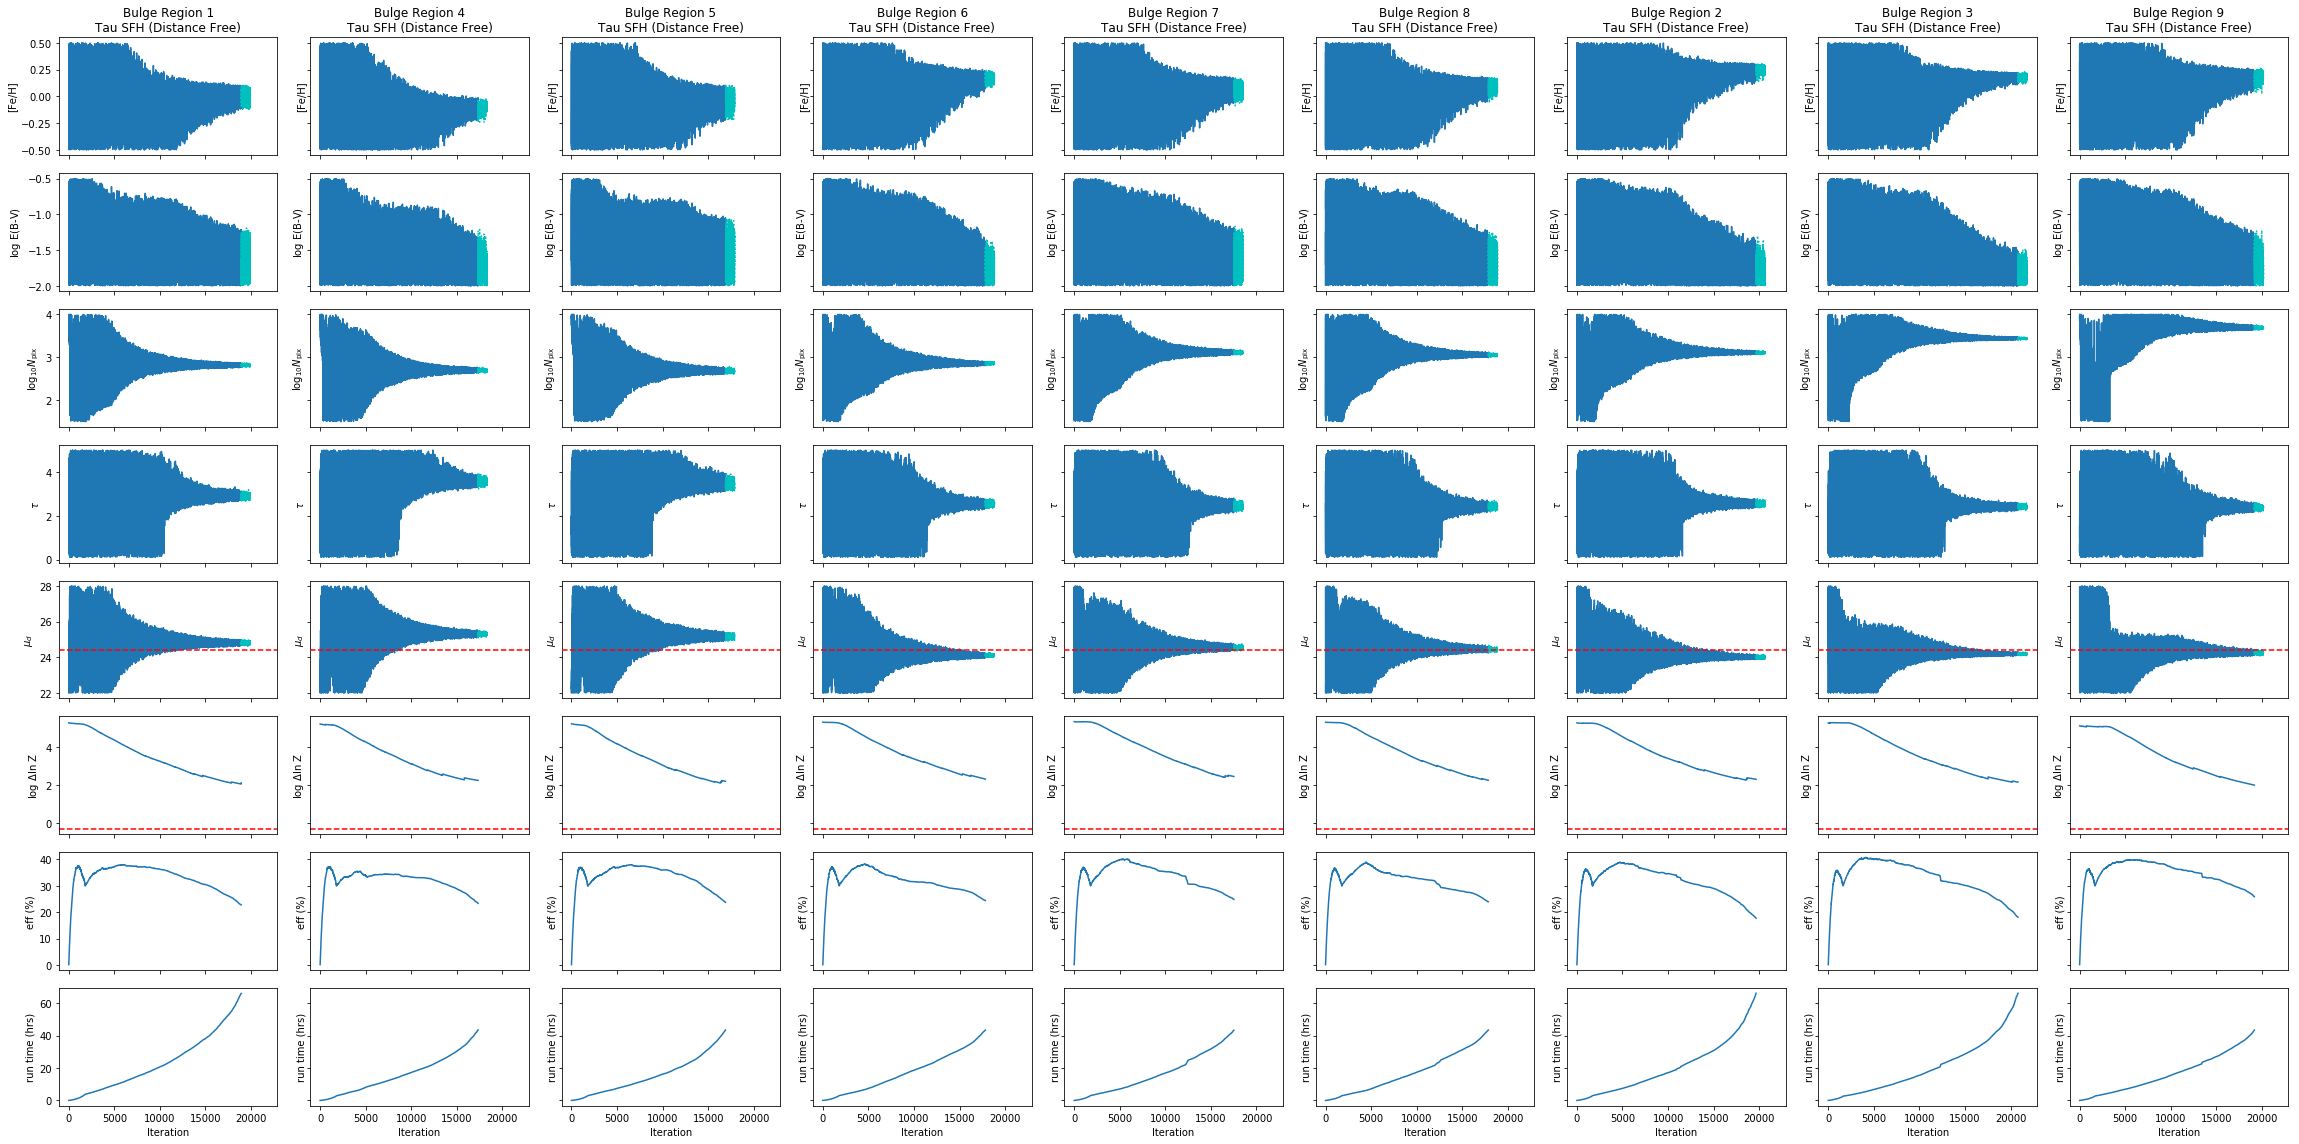

In [16]:
f, a = plot_sets(['model2'], regions=bulge_regions, chains_only=False);

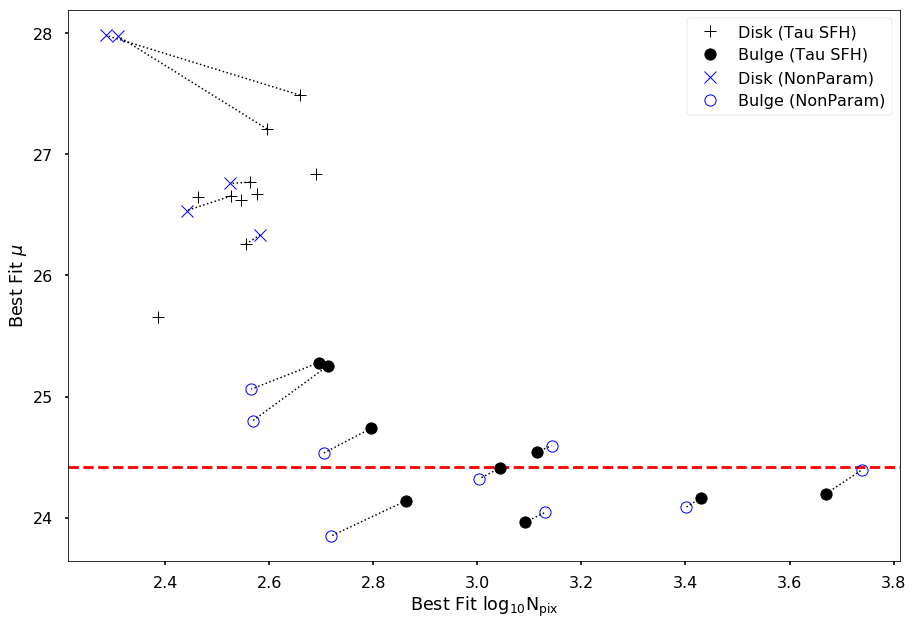

In [66]:
for r in all_regions:
    k = 'model2_'+r
    result = res[k]
    Npix1 = result.best_model.logNpix
    dmod1 = result.best_model.distance_model.dmod
    if 'disk' in season_to_reg[r]:
        dl2 = plt.plot(Npix1, dmod1, 'k+', mew=1)
    else:
        bl2 = plt.plot(Npix1, dmod1, 'ko', mew=1)
    k = 'model4_'+r
    if k not in res:
        continue
    result = res[k]
    Npix2 = result.best_model.logNpix
    dmod2 = result.best_model.distance_model.dmod
    if 'disk' in season_to_reg[r]:
        dl4 = plt.plot(Npix2, dmod2, 'bx', mew=1)
    else:
        bl4 = plt.plot(Npix2, dmod2, 'bo', mfc='None', mew=1)
    plt.plot([Npix1, Npix2], [dmod1, dmod2], 'k:', lw=1.5)
plt.legend((dl2[0], bl2[0], dl4[0], bl4[0]), ('Disk (Tau SFH)', 'Bulge (Tau SFH)', 'Disk (NonParam)', 'Bulge (NonParam)'), loc=0)
plt.axhline(y=24.42, ls='--', color='r', zorder=-1)
plt.xlabel(r'Best Fit $\log_{10} \mathrm{N}_\mathrm{pix}$')
plt.ylabel(r'Best Fit $\mu$');
plt.tight_layout()
plt.savefig('figures/m31_dmod_bias.pdf')

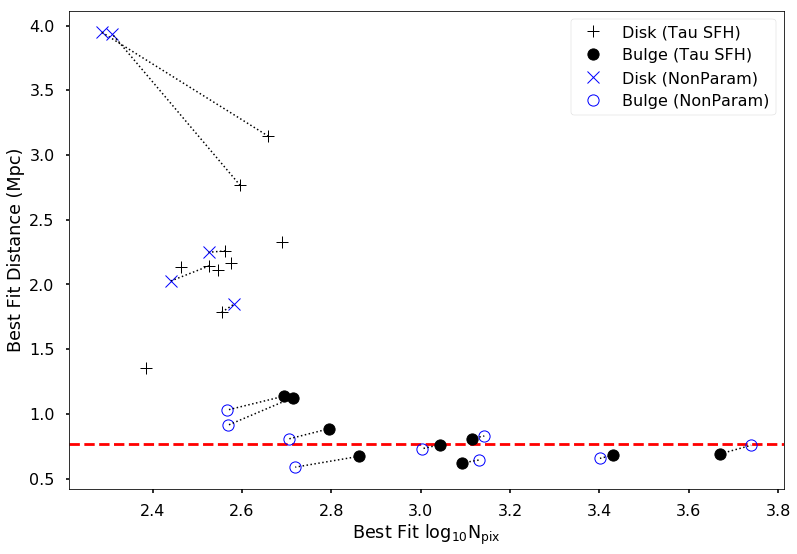

In [67]:
for r in all_regions:
    k = 'model2_'+r
    result = res[k]
    Npix1 = result.best_model.logNpix
    d1 = result.best_model.d_mpc
    if 'disk' in season_to_reg[r]:
        dl2 = plt.plot(Npix1, d1, 'k+', mew=1)
    else:
        bl2 = plt.plot(Npix1, d1, 'ko', mew=1)
    k = 'model4_'+r
    if k not in res:
        continue
    result = res[k]
    Npix2 = result.best_model.logNpix
    d2 = result.best_model.d_mpc
    if 'disk' in season_to_reg[r]:
        dl4 = plt.plot(Npix2, d2, 'bx', mew=1)
    else:
        bl4 = plt.plot(Npix2, d2, 'bo', mfc='None', mew=1)
    plt.plot([Npix1, Npix2], [d1, d2], 'k:', lw=1.5)
plt.legend((dl2[0], bl2[0], dl4[0], bl4[0]), ('Disk (Tau SFH)', 'Bulge (Tau SFH)', 'Disk (NonParam)', 'Bulge (NonParam)'), loc=0)
plt.axhline(y=ppy.distancemodels.dmod_to_mpc(24.42), ls='--', color='r', zorder=-1)
plt.xlabel(r'Best Fit $\log_{10} \mathrm{N}_\mathrm{pix}$')
plt.ylabel(r'Best Fit Distance (Mpc)');
plt.savefig('figures/m31_dist_bias.pdf')

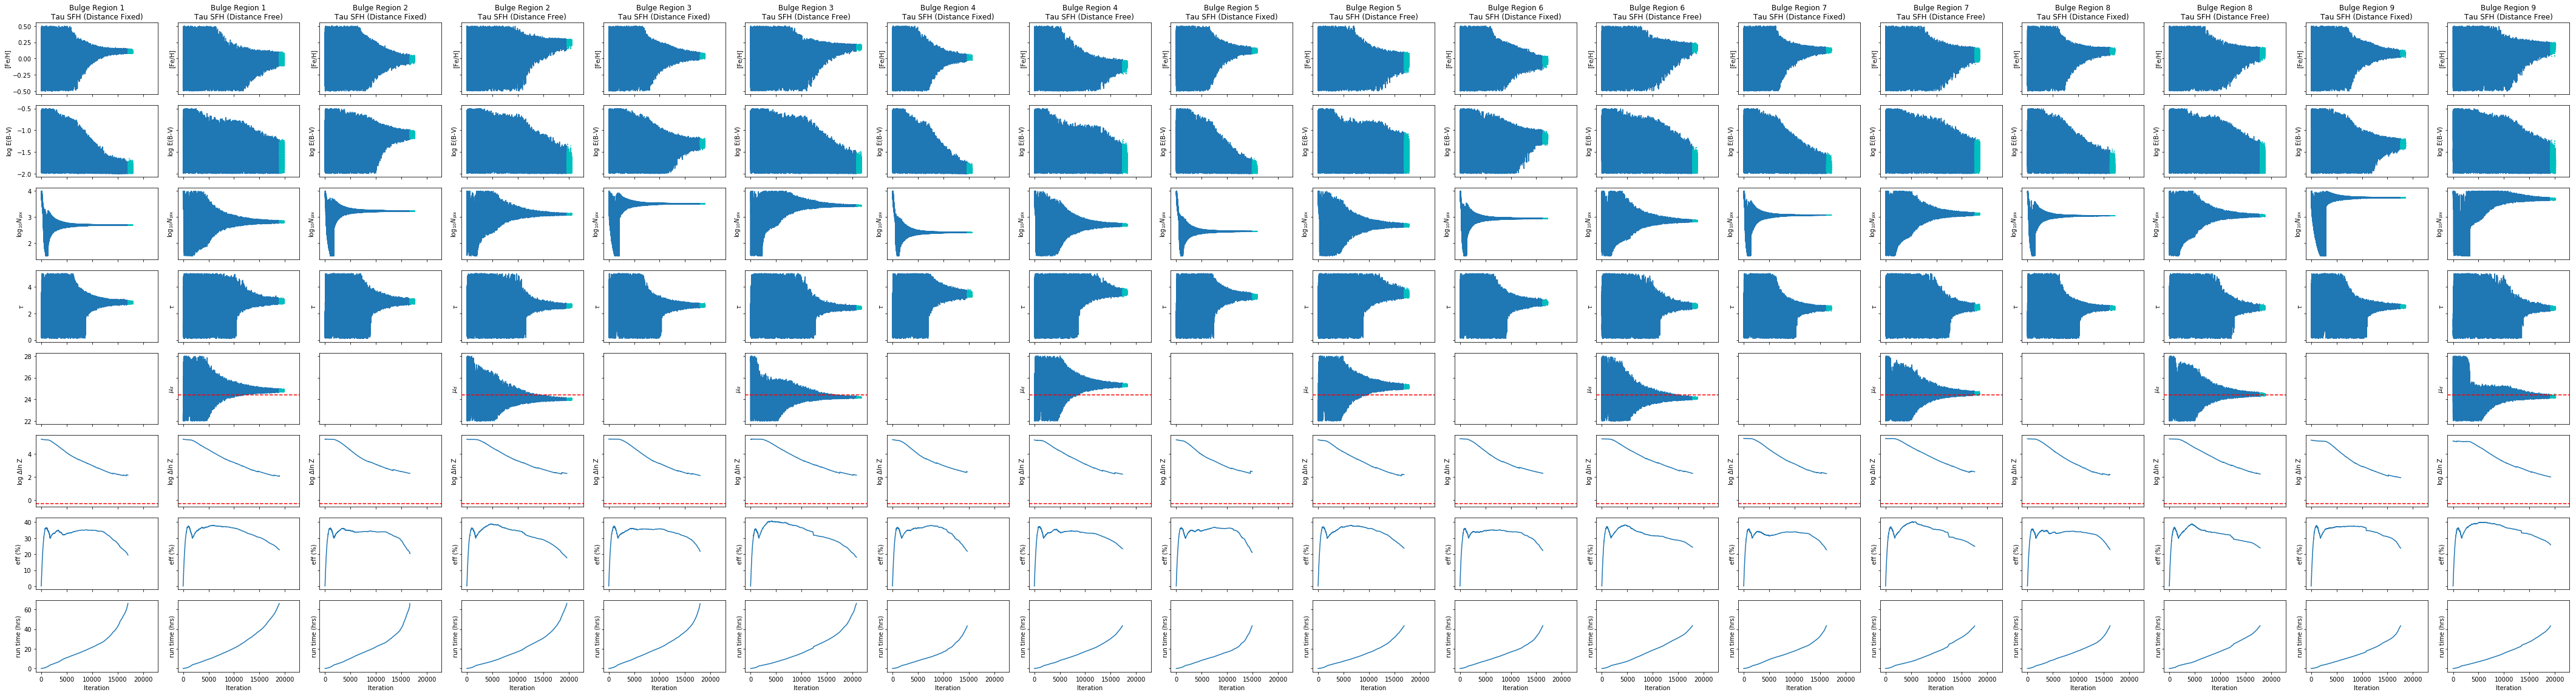

In [49]:
f, a = plot_sets(['model1','model2'], regions=bulge_regions, chains_only=False);

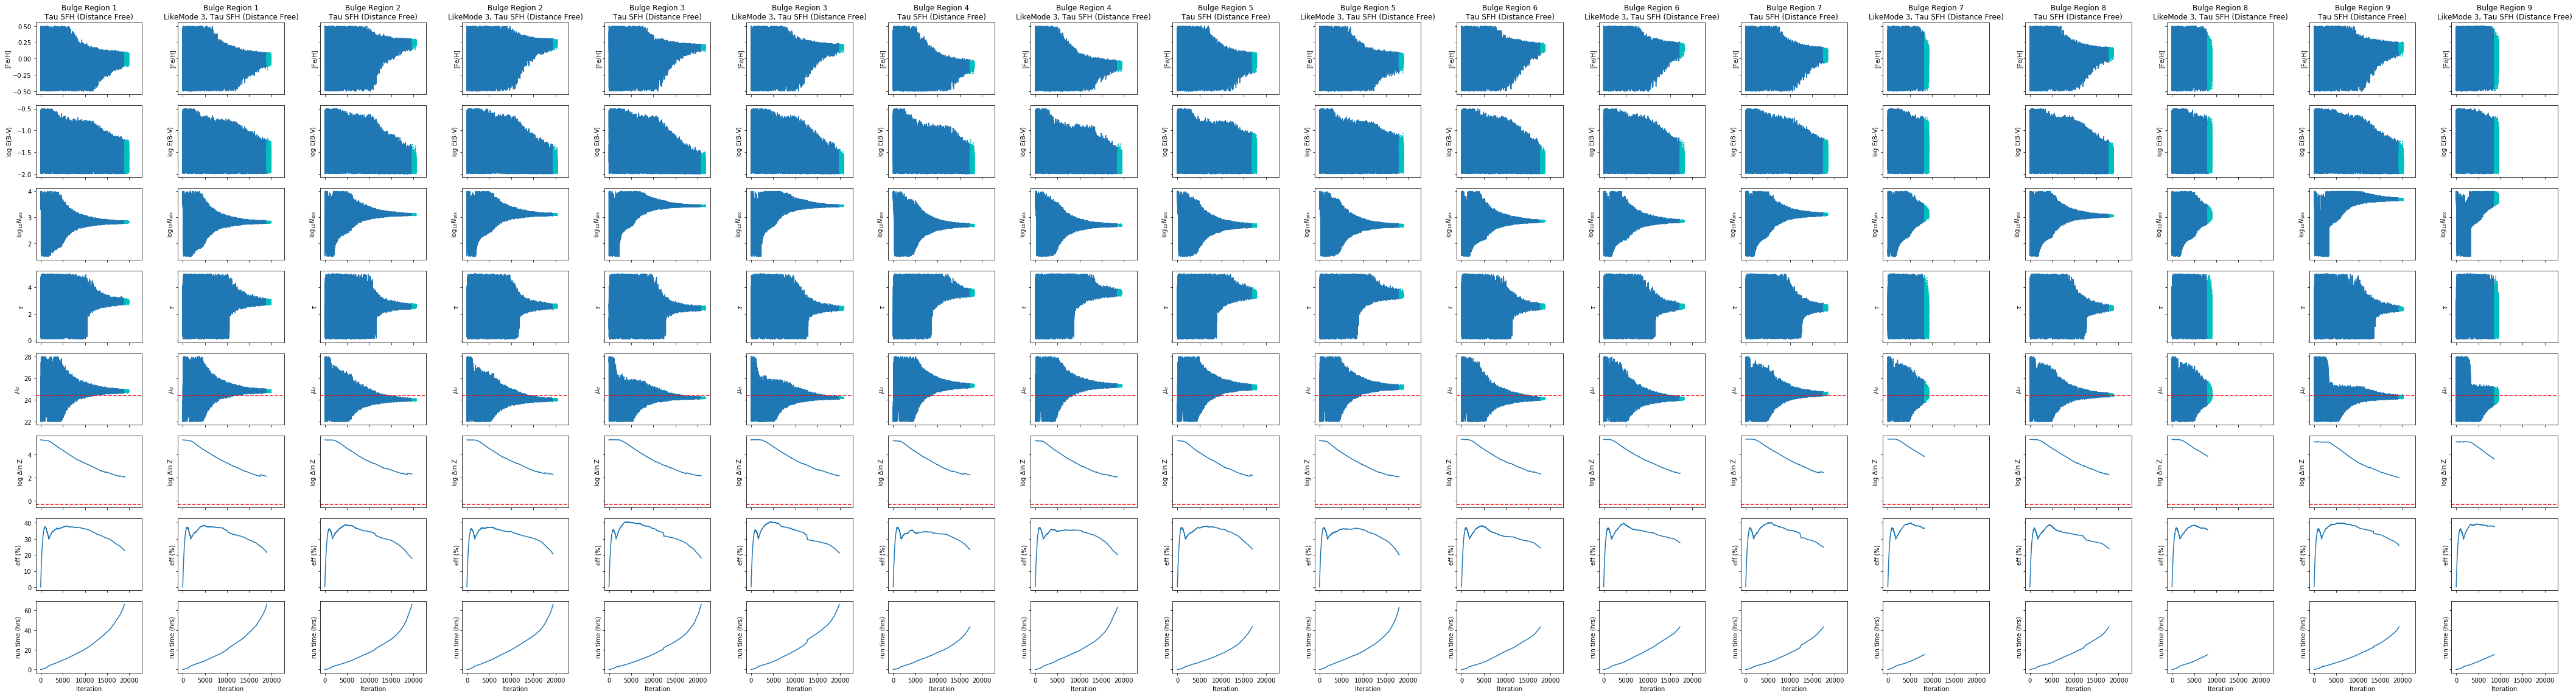

In [47]:
f, a = plot_sets(['model2', 'model3'], regions=bulge_regions, chains_only=False);

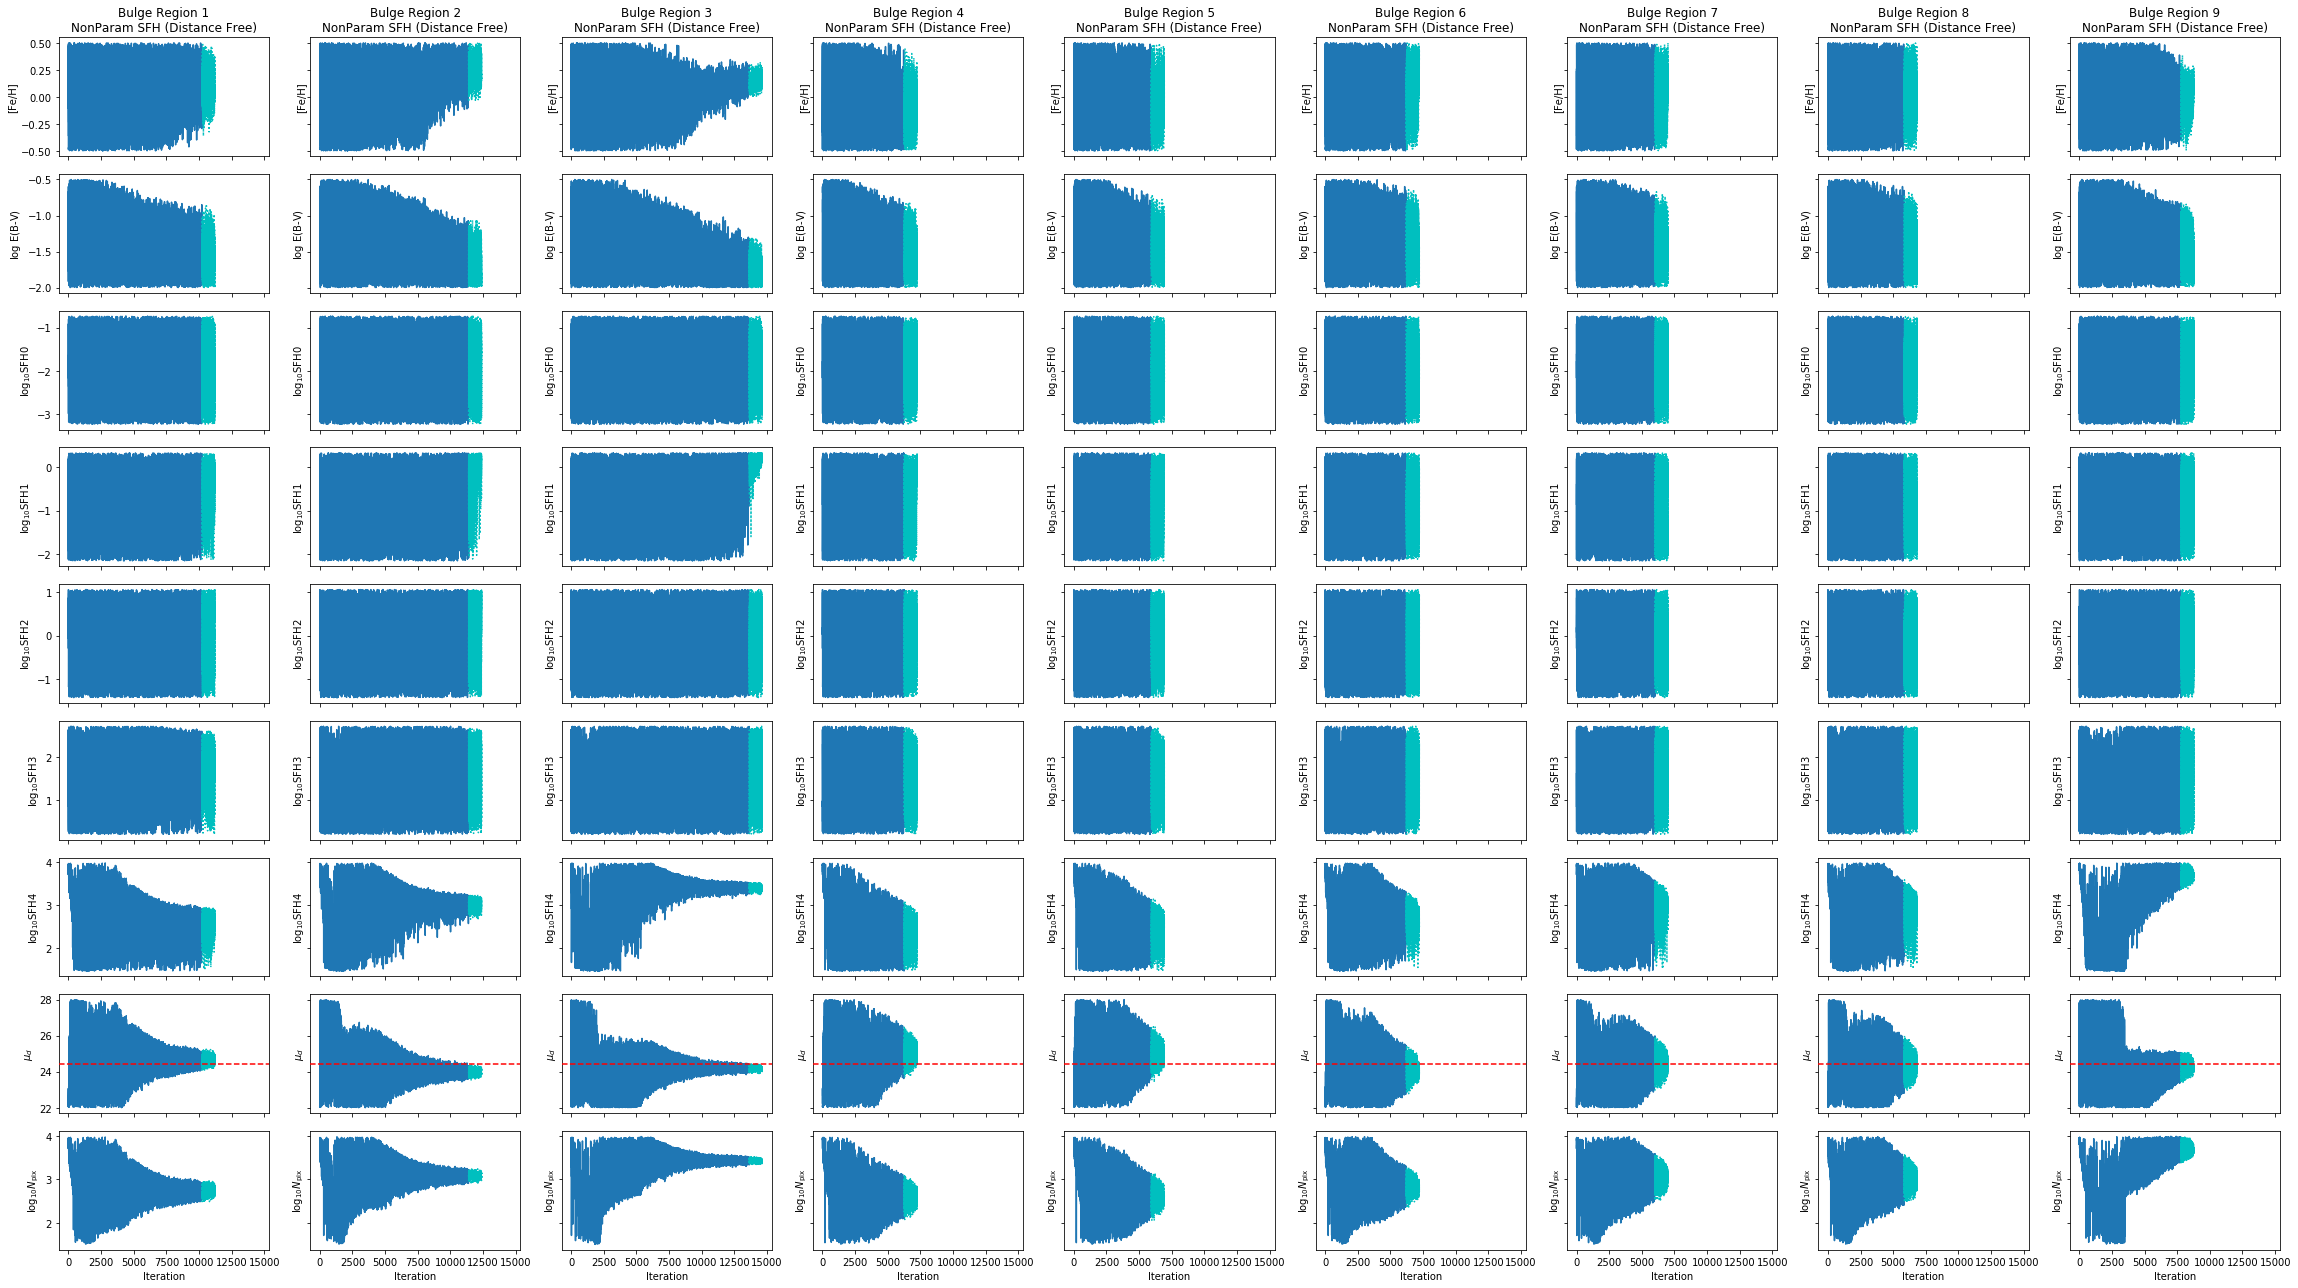

In [48]:
f, a = plot_sets(['model4'], regions=bulge_regions, chains_only=True);

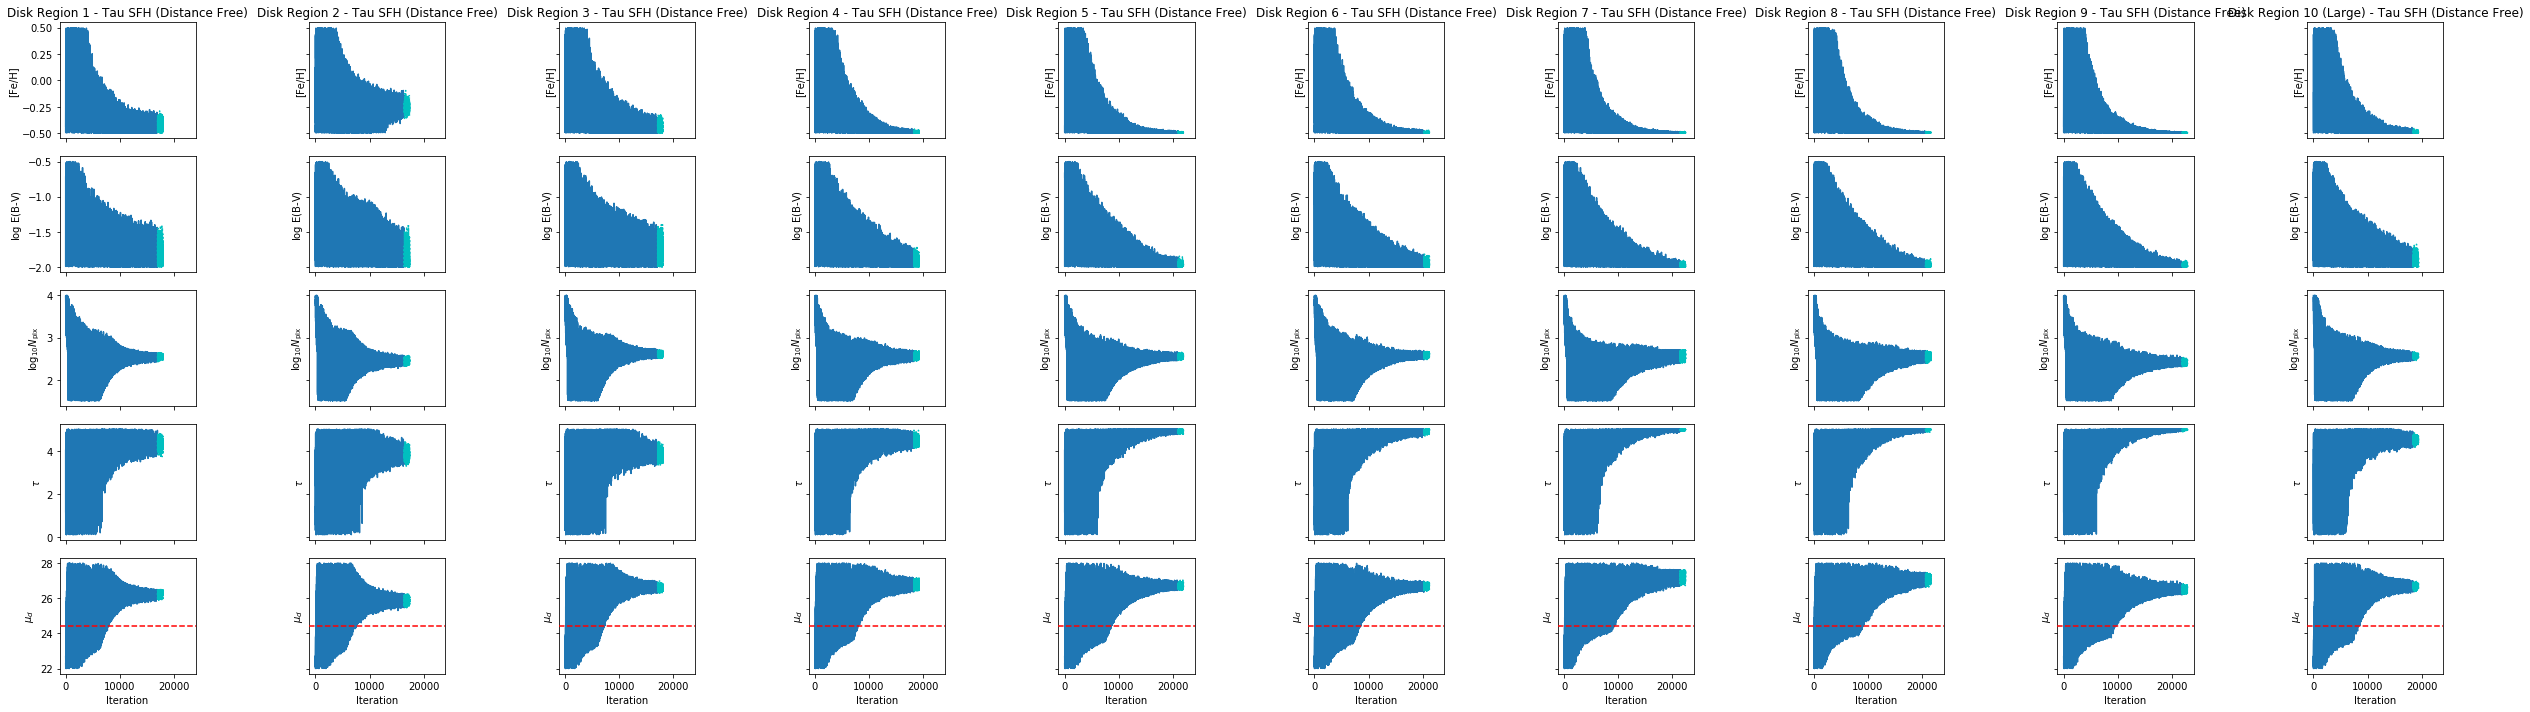

In [19]:
f, a = plot_sets(['model2'], regions=disk_regions, chains_only=True);

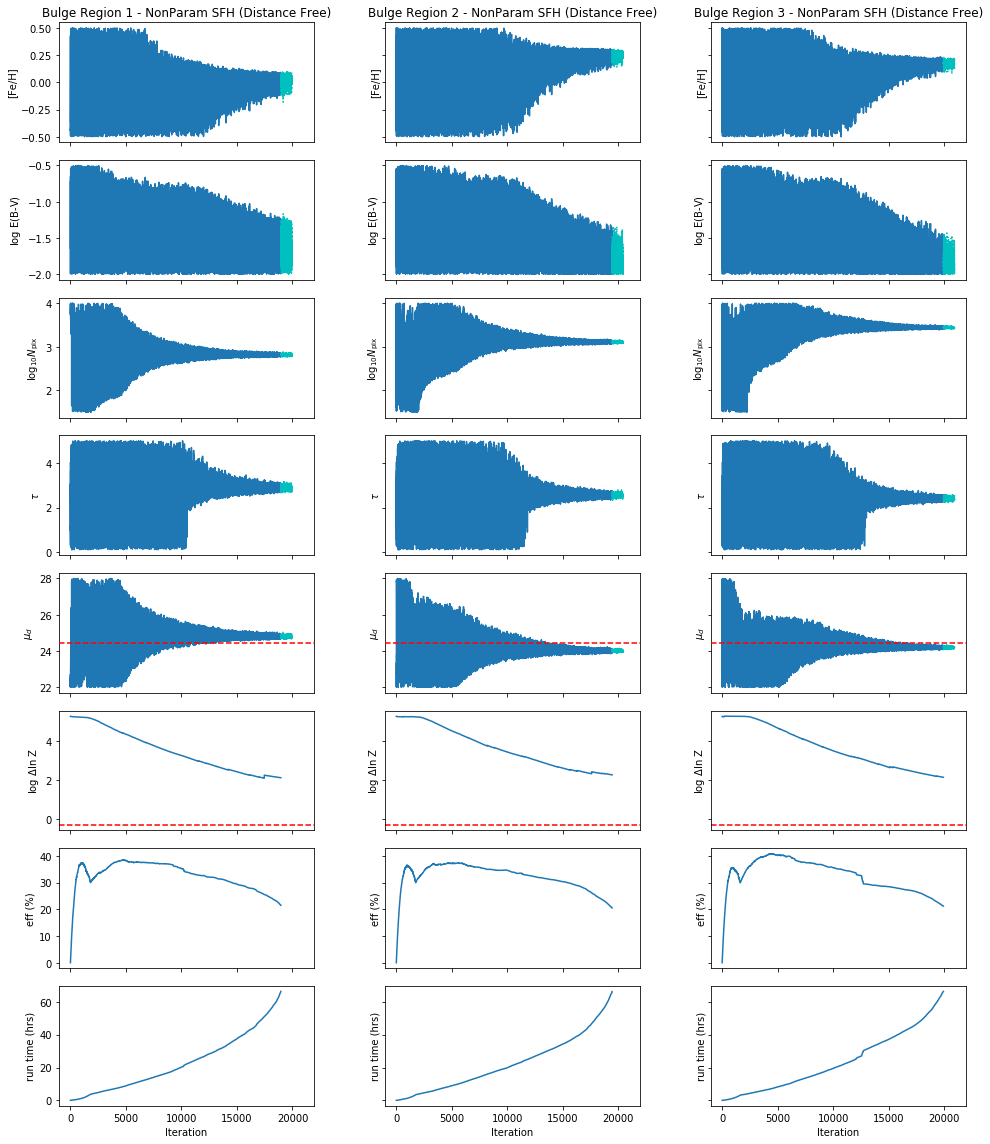

In [20]:
plot_sets(['model3'], regions=bulge_regions, chains_only=False);

In [21]:
res['model2_s1'].best_model.Npix

624.4533502805023

In [22]:
res['model2_w1'].best_model.Npix

1234.2410879360523

In [23]:
res['model2_w2'].best_model.Npix

2693.394692610791

In [24]:
res['model3_s1'].best_model.d_mpc

0.9268298233793496

In [25]:
24.42

24.42

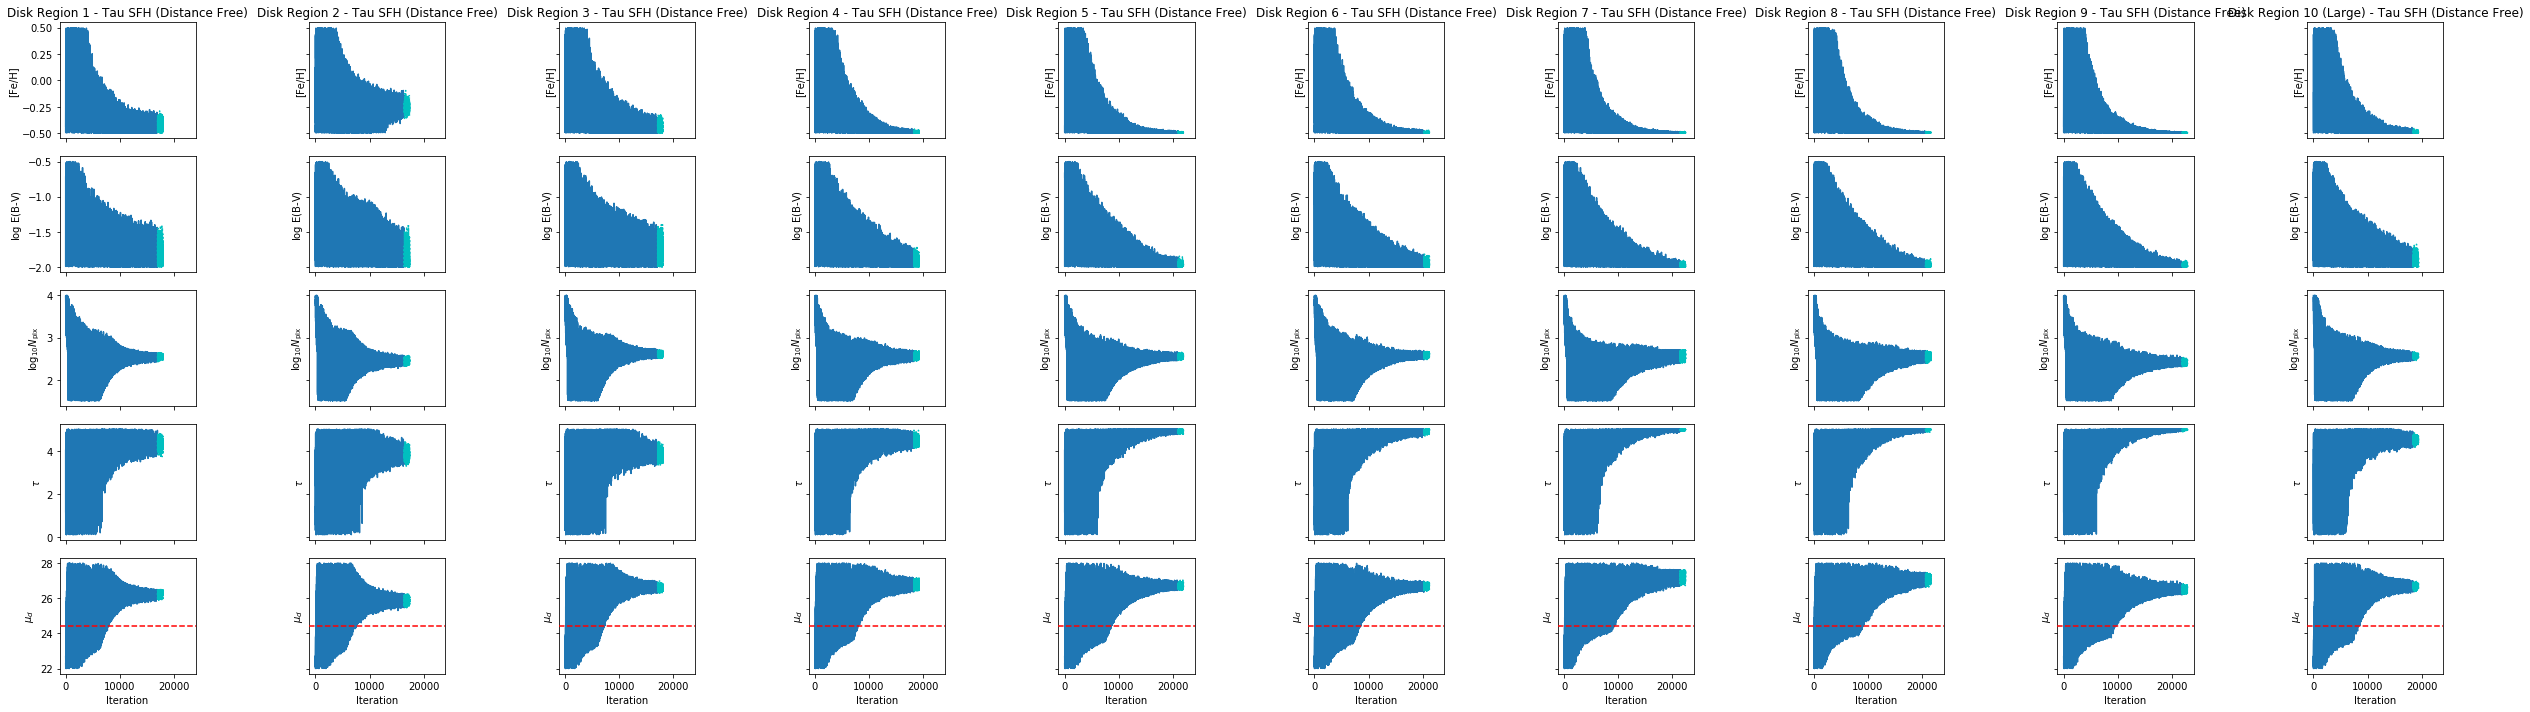

In [26]:
plot_sets(['model2'], regions=disk_regions, chains_only=True);

In [36]:
res['model2_s1'].best_model.Npix / ppy.galaxy.salpeter_meanmass()

702.1169658076134

In [38]:
res['model2_w1'].best_model.Npix / ppy.galaxy.salpeter_meanmass()

1336.009257165502

In [39]:
res['model2_w2'].best_model.Npix / ppy.galaxy.salpeter_meanmass()

2839.288133550427

In [43]:
res['model2_w6'].best_model.Npix / ppy.galaxy.salpeter_meanmass()

382.65682819646895

In [42]:
np.log10(1./ppy.galaxy.salpeter_meanmass())

0.4409094673625564